In this notebook, we'll perform bayesian inference for the logistic regression model using the Polya-Gamma sampler we've developed in the file `polya_gamma.py`.

To set up our problem, we have a dataset of $N$ examples $\{(x_i, y_i)\}_{i=1}^N$ where

$x_i = (x_{i,1},\ldots,x_{i,M}) \in \mathbb{R}^M$

is a vector of regressors and

$y_i \in \{0,1\}$

is a response; our logistic regression model makes the assumption that

$y_i \sim Bern(1/(1+e^{\psi_i}))$

where

$\psi_i = x_i^\top\beta$

represents the log-odds of the probabilities of success and failure:

$\psi_i = \log(p_i / (1-p_i))$,

so that

$1/(1+e^{\psi_i}) = p_i$.

The $\beta$ vector of regressor weights has a Normal prior $\mathcal{N}(\mu, \Sigma)$; we want a way to sample directly from the posterior density $p(\beta | Y, X)$.

According to Polson et al, the following two-step Gibbs sampler will allow us to directly sample from the posterior, by iterating back and forth between the following sampling operations:

$ \forall i \in [N], (\omega_i | \beta) \sim PG(1, x_i^\top\beta) \iff (\beta | y, \omega) \sim \mathcal{N}(m_\omega, V_\omega)$,

where:

* $V_\omega := (X^\top \Omega X + \Sigma^{-1})^{-1}$,
* $m_\omega := V_\omega(X^\top\kappa + \Sigma^{-1}\mu)$,
* $\Omega := diag(\omega_1, \omega_2, \ldots, \omega_N)$, and
* $\kappa := (y_1 - \frac{1}{2}, y_2 - \frac{1}{2}, \ldots, y_N - \frac{1}{2})$.

In [1]:
import numpy as np
import scipy.stats as stats
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

- - - - -
# 1. Testing the Polya-Gamma Sampler

Let's first make sure our sampler for $PG(b,z)$ (for $b$ a positive integer and $z$ an arbitrary real) works as intended. It's implemented in this directory via file `polya_gamma.py`. We'll replicate the two plots in Figure 3 of Polson et al.

In [2]:
from polya_gamma import polya_gamma_rv

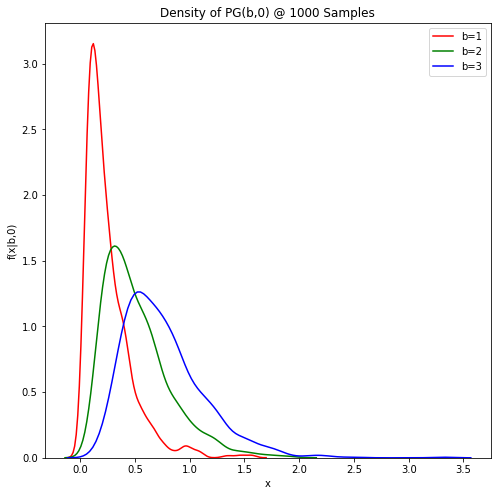

In [3]:
# replicate figure from the paper:
rvs_b1_z0 = [polya_gamma_rv(b=1, z=0.0) for _ in range(1000)]
rvs_b2_z0 = [polya_gamma_rv(b=2, z=0.0) for _ in range(1000)]
rvs_b3_z0 = [polya_gamma_rv(b=3, z=0.0) for _ in range(1000)]
plt.figure(figsize=(8,8))
sns.distplot(rvs_b1_z0, kde=True, hist=False, color='r', label='b=1')
sns.distplot(rvs_b2_z0, kde=True, hist=False, color='g', label='b=2')
sns.distplot(rvs_b3_z0, kde=True, hist=False, color='b', label='b=3')
plt.xlabel('x')
plt.ylabel('f(x|b,0)')
_ = plt.title('Density of PG(b,0) @ 1000 Samples')

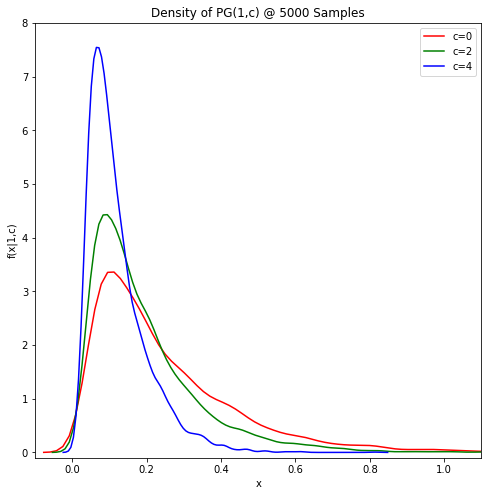

In [4]:
# replicate figure 3 from the paper supplement:
rvs_b1_c0 = [polya_gamma_rv(b=1, z=0.0) for _ in range(5000)]
rvs_b1_c2 = [polya_gamma_rv(b=1, z=2.0) for _ in range(5000)]
rvs_b1_c4 = [polya_gamma_rv(b=1, z=4.0) for _ in range(5000)]
plt.figure(figsize=(8,8))
sns.distplot(rvs_b1_c0, kde=True, hist=False, color='r', label='c=0')
sns.distplot(rvs_b1_c2, kde=True, hist=False, color='g', label='c=2')
sns.distplot(rvs_b1_c4, kde=True, hist=False, color='b', label='c=4')
plt.xlabel('x')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1, 8.0)
plt.ylabel('f(x|1,c)')
_ = plt.title('Density of PG(1,c) @ 5000 Samples')

- - - - -
# 2. Bayesian Inference for Logistic Regression: benchmarks

We compare frequentist logistic regression against the Gibbs sampling method for the posterior on a synthetic dataset used by the authors Polson et al.

In [5]:
# import necessary tools:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [6]:
# tidy function that implements our posterior density gibbs sampler:
def sample_posterior_logistic_regression(beta_mean, beta_cov, X, Y, burnin=20, nsamples=100):
    """
    Given a beta RV with a multivariate normal prior N(beta_mean, beta_cov), sample from the
    posterior distribution (beta | y, omega) using a data-augmentation strategy that assumes
    a polya-gamma-distributed latent variable omega.
    
    Args:
    * beta_mean: ndarray of shape (D,)
    * beta_cov: ndarray of shape (D,D)
    * X: ndarray of shape (N,D)
    * Y: ndarray of shape (N), all values either 0. or 1.
    * burnin: int
    * nsamples: int
    """
    beta = stats.multivariate_normal.rvs(mean=beta_mean, cov=beta_cov)
    posterior_samples = []
    for _ in tqdm(range(burnin + nsamples)):
        # first step:
        psis = np.dot(X,beta)
        omegas = np.array([ polya_gamma_rv(1, psis[k]) for k in range(psis.shape[0]) ])
        # second step:
        kappa = Y - (np.ones_like(Y) * 0.5)
        inv_covar = np.linalg.inv(beta_cov)
        V_omega = np.linalg.inv(X.T @ np.diag(omegas) @ X + inv_covar)
        m_omega = V_omega @ (np.dot(X.T, kappa) + np.dot(inv_covar,beta_mean))
        beta = stats.multivariate_normal.rvs(mean=m_omega, cov=V_omega)
        # append sample to list of samples
        posterior_samples.append(beta)
    return np.array(posterior_samples)

- - - - -
Let's have a quick trial run of our gibbs sampler with a fake data matrix, just to make sure it works; we'll use a very wide prior distribution for beta. We should expect to see a much sharper posterior distribution.

In [7]:
_TEST_X = np.concatenate([np.random.randn(5,3), np.random.randn(5,3) * 0.5], axis=0)
_TEST_POSTERIOR_SAMPLES = sample_posterior_logistic_regression(
    beta_mean=np.zeros(3), beta_cov=np.diag(np.ones(3) * 0.1),
    X=_TEST_X, Y=np.concatenate([np.ones(5), np.zeros(5)],axis=0),
    burnin=20, nsamples=100)
_TEST_MVN_SAMPLES = stats.multivariate_normal.rvs(mean=np.zeros(3), cov=np.diag(np.ones(3)), size=100)

100%|██████████| 120/120 [00:00<00:00, 255.40it/s]


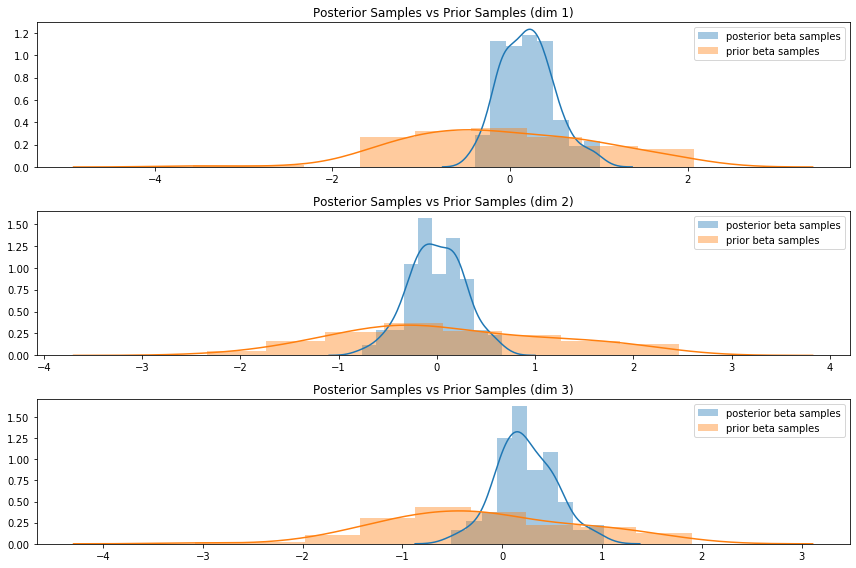

In [8]:
plt.figure(figsize=(12,8))

plt.subplot(3,1,1)
sns.distplot(_TEST_POSTERIOR_SAMPLES[:,0], label='posterior beta samples')
sns.distplot(_TEST_MVN_SAMPLES[:,0], label='prior beta samples')
plt.legend(loc='best')
plt.title("Posterior Samples vs Prior Samples (dim 1)")

plt.subplot(3,1,2)
sns.distplot(_TEST_POSTERIOR_SAMPLES[:,1], label='posterior beta samples')
sns.distplot(_TEST_MVN_SAMPLES[:,1], label='prior beta samples')
plt.legend(loc='best')
plt.title("Posterior Samples vs Prior Samples (dim 2)")

plt.subplot(3,1,3)
sns.distplot(_TEST_POSTERIOR_SAMPLES[:,2], label='posterior beta samples')
sns.distplot(_TEST_MVN_SAMPLES[:,2], label='prior beta samples')
plt.legend(loc='best')
plt.title("Posterior Samples vs Prior Samples (dim 3)")

plt.tight_layout()

- - - - -
Now let's see how this performs on a real dataset. We'll import the [Pima Indian](https://www.kaggle.com/uciml/pima-indians-diabetes-database) dataset, which records health-related features and diabetes status for a group of people from the Pima Indigenous group of Arizona, and further perform some cleaning to remove rows containing a zero in any of the feature columns before splitting into `X` (feature) and `Y` (target) arrays.

In [9]:
import pandas as pd
data = pd.read_csv("data/datasets_228_482_diabetes.csv")

In [10]:
print("Shape of dataset: {}".format(data.shape))
data.head(10)

Shape of dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [11]:
# remove all rows where a zero exists in any of column Pregnancies:Age (but *not* outcome!!):
data_fmt = data[~(data.loc[:,'Pregnancies':'Age'] == 0).any(axis=1)]
data_fmt.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
14,5,166,72,19,175,25.8,0.587,51,1
18,1,103,30,38,83,43.3,0.183,33,0
19,1,115,70,30,96,34.6,0.529,32,1
20,3,126,88,41,235,39.3,0.704,27,0
24,11,143,94,33,146,36.6,0.254,51,1
25,10,125,70,26,115,31.1,0.205,41,1


In [12]:
# check that the mean outcome is around 0.33, which is the value in the paper:
print("Mean outcome of our dataset (should be approx. 0.33): {}".format(data_fmt.Outcome.mean()))

Mean outcome of our dataset (should be approx. 0.33): 0.33035714285714285


In [13]:
X, Y = data_fmt.loc[:, 'Pregnancies':'Age'].values, data_fmt.loc[:, 'Outcome'].values

In [14]:
# housekeeping: convert to homogeneous datatypes
X = X.astype(np.float)
Y = Y.astype(np.float)

Looks good! Now let's fit a (frequentist) logistic regression model, courtesy of the implementation in `sklearn`:

In [15]:
frequentist_logr_model = LogisticRegression(fit_intercept=False, max_iter=100, verbose=1)
frequentist_logr_model.fit(X,Y)

[LibLinear]

/home/ptsw/src/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=1,
                   warm_start=False)

In [16]:
# hold onto our beta coefficients for comparison:
beta_mle = frequentist_logr_model.coef_[0]
for idx in range(beta_mle.shape[0]):
    print("* beta coef {} = {:.4f}".format(idx, beta_mle[idx]))

* beta coef 0 = 0.1552
* beta coef 1 = 0.0150
* beta coef 2 = -0.0421
* beta coef 3 = 0.0307
* beta coef 4 = 0.0028
* beta coef 5 = -0.0577
* beta coef 6 = 0.3196
* beta coef 7 = 0.0065


- - - - -
Finally, let's now sample from the posterior with our gibbs sampler, based on a wide normally-distributed prior for beta:

$\beta \sim \mathcal{N}(\mathbb{0}, diag(\mathbb{1}))$

(Note that given the small magnitude of the beta MLE, a standard normal is considered "wide" for our purposes.)

In [37]:
beta_post_samples = sample_posterior_logistic_regression(
    beta_mean=np.zeros(8), beta_cov=np.diag(np.ones(8) * 1.0),
    X=X, Y=Y, burnin=20, nsamples=100)

100%|██████████| 120/120 [00:15<00:00,  8.04it/s]


Now let's see how the beta coefficients discovered by sklearn compare with our posterior inferences:

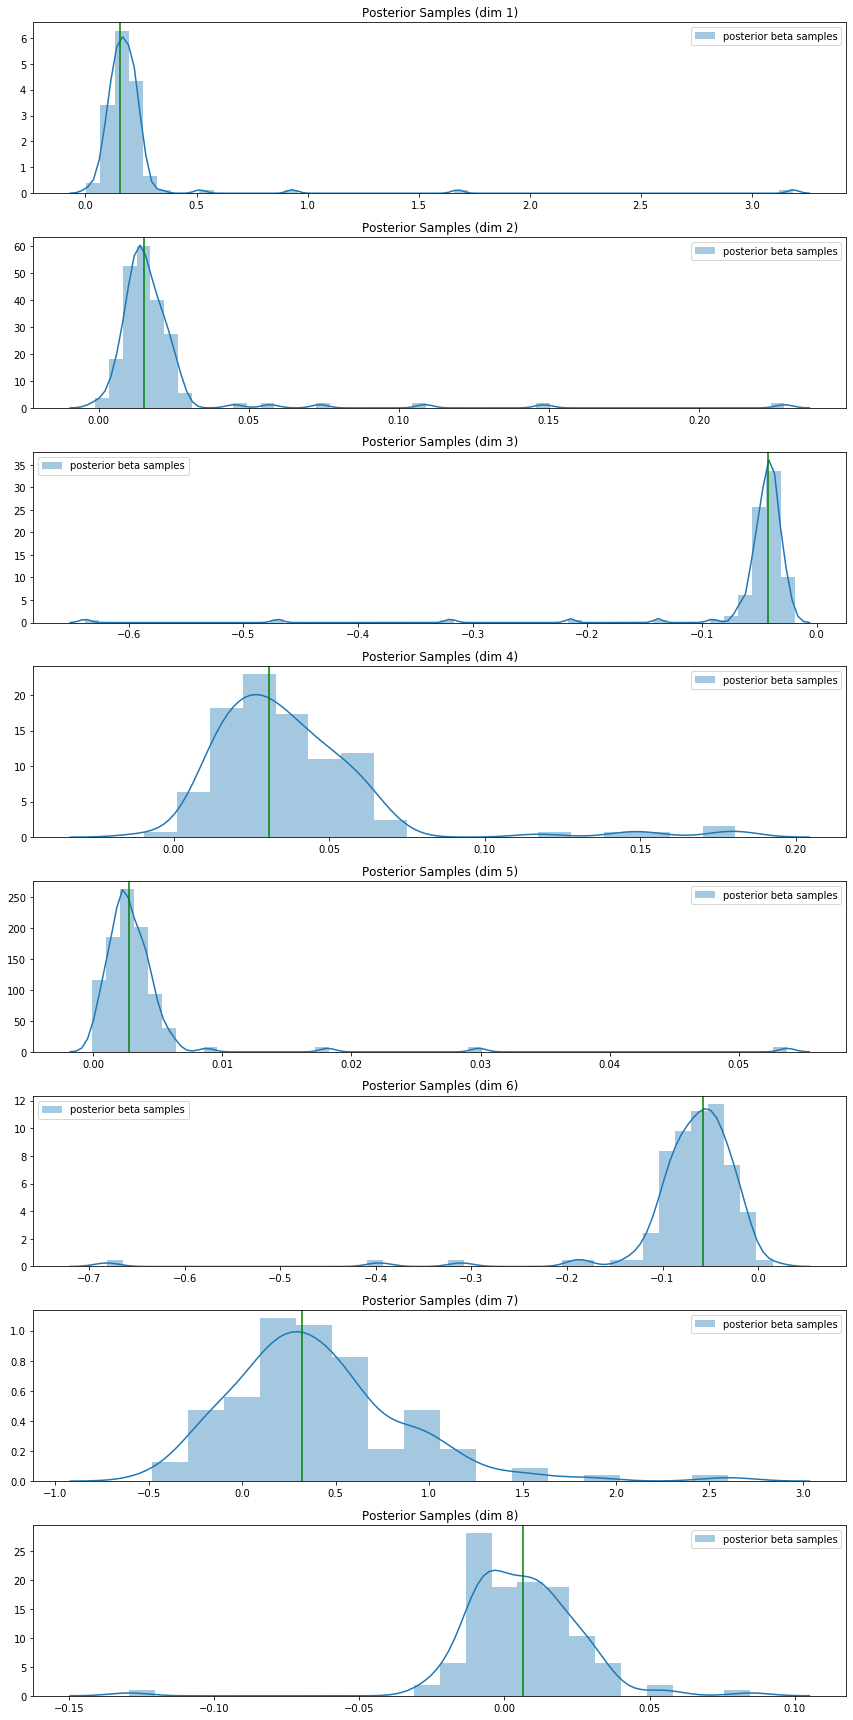

In [38]:
plt.figure(figsize=(12,24))

plt.subplot(8,1,1)
sns.distplot(beta_post_samples[:,0], label='posterior beta samples')
plt.axvline(beta_mle[0], color='g')
plt.legend(loc='best')
plt.title("Posterior Samples (dim 1)")

plt.subplot(8,1,2)
sns.distplot(beta_post_samples[:,1], label='posterior beta samples')
plt.axvline(beta_mle[1], color='g')
plt.legend(loc='best')
plt.title("Posterior Samples (dim 2)")

plt.subplot(8,1,3)
sns.distplot(beta_post_samples[:,2], label='posterior beta samples')
plt.axvline(beta_mle[2], color='g')
plt.legend(loc='best')
plt.title("Posterior Samples (dim 3)")

plt.subplot(8,1,4)
sns.distplot(beta_post_samples[:,3], label='posterior beta samples')
plt.axvline(beta_mle[3], color='g')
plt.legend(loc='best')
plt.title("Posterior Samples (dim 4)")

plt.subplot(8,1,5)
sns.distplot(beta_post_samples[:,4], label='posterior beta samples')
plt.axvline(beta_mle[4], color='g')
plt.legend(loc='best')
plt.title("Posterior Samples (dim 5)")

plt.subplot(8,1,6)
sns.distplot(beta_post_samples[:,5], label='posterior beta samples')
plt.axvline(beta_mle[5], color='g')
plt.legend(loc='best')
plt.title("Posterior Samples (dim 6)")

plt.subplot(8,1,7)
sns.distplot(beta_post_samples[:,6], label='posterior beta samples')
plt.axvline(beta_mle[6], color='g')
plt.legend(loc='best')
plt.title("Posterior Samples (dim 7)")

plt.subplot(8,1,8)
sns.distplot(beta_post_samples[:,7], label='posterior beta samples')
plt.axvline(beta_mle[7], color='g')
plt.legend(loc='best')
plt.title("Posterior Samples (dim 8)")

plt.tight_layout()

Looks great!

Why don't we also check out the distribution of euclidean norms between the beta MLE and the posterior betas?

* Mean euclidean norm: 0.3805615051942224
* Median euclidean norm: 0.27524806681477376


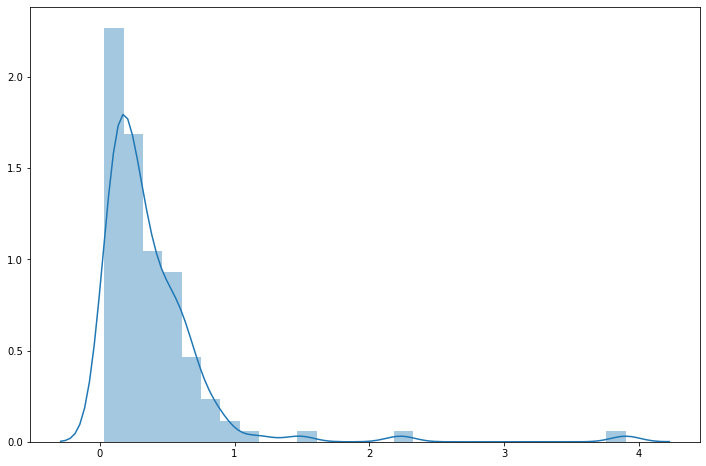

In [39]:
euclidean_distances = np.linalg.norm(beta_post_samples - beta_mle, axis=1)

plt.figure(figsize=(12,8))
sns.distplot(euclidean_distances)
print("* Mean euclidean norm: {}".format(np.mean(euclidean_distances)))
print("* Median euclidean norm: {}".format(np.median(euclidean_distances)))

- - - - -

... And there you have it! A quick way to perform bayesian logistic regression, by way of a fast sampling method.

Note also that this same approach --- using the Polya-Gamma sampler to construct a latent-variable-based gibbs sampler for count-based models --- can be extended to bayesian inference for binomial regression and other models. It's an incredibly flexible technique, and I encourage you to delve further into it to find out more about this fascinating class of distributions.

See [_Bayesian inference for logistic models using Polya-Gamma latent variables_](https://arxiv.org/abs/1205.0310), by Polson, Scott, and Windle, for further details (including lengthy proofs of correctness).

Thanks for reading!